<a href="https://colab.research.google.com/github/irissun9602/Mouse-Dynamics/blob/main/MouseDynamics_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Loading essential libraries

In [ ]:
import glob, os, csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
import os
import pandas as pd

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Understanding Input Data File

####Load training data of user7 and save as a dataframe.
,Check columns and unique values which has values of type string

In [ ]:
# 사용자 폴더 목록
user_folders = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9', 'user10', 'user11']  # 사용자 폴더를 필요에 따라 추가

# 모든 CSV 파일을 저장할 빈 데이터프레임 생성
df = pd.DataFrame()

# 각 사용자 폴더에 대해 CSV 파일을 읽어와서 리스트에 추가
for user_folder in user_folders:
    folder_path = f'/content/drive/MyDrive/Colab Notebooks/Mouse-Dynamics-Challenge-master/Mouse-Dynamics-Challenge-master/training_files/{user_folder}/'

    # 해당 폴더에 있는 모든 CSV 파일 목록 가져오기
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # 각 CSV 파일을 읽어와서 리스트에 추가
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        cs = pd.read_csv(file_path)
        new_columns = ['record timestamp', 'client timestamp', 'button', 'state', 'x', 'y']
        cs.columns = new_columns
        cs['y_label'] = user_folder.replace('user', '')

        df = pd.concat([df, cs], ignore_index=True)

# 결과 출력
print(df)

         record timestamp  client timestamp       button             state  \
0                    1.29              1.29  Button.left          Released   
1                    1.34              1.34          NaN              move   
2                    1.34              1.34          NaN              move   
3                    1.36              1.36          NaN              move   
4                    1.36              1.36          NaN              move   
...                   ...               ...          ...               ...   
4620819            598.35            598.35       Scroll  Scrolled (0, -1)   
4620820            598.36            598.36          NaN              move   
4620821            598.37            598.37       Scroll  Scrolled (0, -1)   
4620822            598.38            598.38       Scroll  Scrolled (0, -1)   
4620823            598.39            598.39       Scroll  Scrolled (0, -1)   

            x    y y_label  
0         121  154       1  
1    

####Mapping columns with string fields to integer values

In [ ]:
df["button"].fillna(0, inplace=True)

In [ ]:
di = {'NoButton': 0, 'Left': 1, 'Right': 2, 'Button.left': 1, 'Button.right': 2, 'Button.middle': 3, 'Scroll' : 4, 'Button.x1' :5}
dj = {'Move': 0, 'move' : 0, 'Pressed': 1, 'Released' : 2, 'Drag' : 3, 'Up' : 4, 'Down' : 5, 'Scrolled (0, 1)' : 6, 'Scrolled (0, -1)' : 7, 'Clicked' :1, 'Scrolled (0, -2)' : 8, 'Scrolled (0, 2)' : 9, 'Scrolled (0, 0)' :10, 'Scrolled (-1, 0)' :11}
df["button"].replace(di, inplace=True)
df["state"].replace(dj, inplace=True)
print(df.head(10))
# print(df.describe())

   record timestamp  client timestamp button state    x    y y_label
0              1.29              1.29      1     2  121  154       1
1              1.34              1.34      0     0  134  160       1
2              1.34              1.34      0     0  158  167       1
3              1.36              1.36      0     0  180  177       1
4              1.36              1.36      0     0  201  184       1
5              1.37              1.37      0     0  220  191       1
6              1.37              1.37      0     0  235  197       1
7              1.39              1.39      0     0  250  204       1
8              1.39              1.39      0     0  261  208       1
9              1.40              1.40      0     0  270  212       1


###Feature Extraction

####Sort data according to column 'client timestamp' then calculate time taken between mouse movements, speed of mouse movements, curvature and radius of curvature

Features identified :
1. time between mouse movements
2. mouse speed
3. mouse movement arc curvature
4. frequency of  mouse clicks

In [ ]:
df.sort_values("client timestamp")
#df.insert(0, "Serial_no", range(0,len(df.index.values)))
df["delta_client_time"] = df["client timestamp"].diff(-1)
df["delta_client_time"] = df["delta_client_time"].abs()
df["delta_x"] = df["x"].diff(-1)
df["delta_y"] = df["y"].diff(-1)
df["delta_dist"] = np.sqrt( (df["delta_x"])**2 + (df["delta_y"])**2 )
df["mouse_speed"] = np.where(df["delta_client_time"] != 0, df["delta_dist"] / df["delta_client_time"], np.nan)
df["mouse_speed"] = df["mouse_speed"].abs()
df["slope"] = np.where(df["delta_x"] != 0, df["delta_y"] / df["delta_x"], np.nan)
df["delta_slope"] = df["slope"].diff(-1)
df["curvature"] = np.where(df["delta_x"] != 0, df["delta_slope"] / df["delta_x"], np.nan)
df["curvature"] = df["curvature"].abs()
# df["radius_of_curvature"] = 1 / df["curvature"]

Note: The curvature is important as if it has many values as zero, it means the mouse is moving in a perfectly straight line for longer periods, which is more likely a bot like behavior.

####Frequency of mouse clicks varying with client timestamp

In [ ]:
# clicks_so_far, click_frequency 계산 및 무한대 값 처리
clicks_so_far = []
for index, row in df.iterrows():
    if index != 0:
        clicks_so_far.append(clicks_so_far[-1] + (1 if row["button"] != 0 else 0))
    else:
        clicks_so_far.append(1 if row["button"] != 0 else 0)

df['clicks_so_far'] = clicks_so_far
df['click_frequency'] = df['clicks_so_far'] / df['client timestamp'].replace(0, 1)  # 0으로 나누는 것 방지

# inf 값을 0으로 처리
df['click_frequency'] = df['click_frequency'].replace([np.inf, -np.inf], 0)

In [ ]:
df1 = df.dropna()
df1.describe()


,record timestamp,client timestamp,x,y,delta_client_time,delta_x,delta_y,delta_dist,mouse_speed,slope,delta_slope,curvature,clicks_so_far,click_frequency
count,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,913031.000000,9.130310e+05
mean,279.893137,279.893137,1269.600554,591.193613,0.111418,-0.016814,0.030003,11.154970,1044.636707,-0.120981,-0.013608,0.307706,52900.170011,2.000985e+03
std,180.196237,180.196237,1177.268614,370.526295,6.539479,23.674222,13.575888,24.906650,1986.236776,2.159414,2.037148,1.485202,25612.738940,3.170505e+04
min,0.010000,0.010000,-1661.000000,-650.000000,0.010000,-4788.000000,-964.000000,1.000000,0.003381,-108.500000,-627.696498,0.000000,1.000000,6.997901e-02
25%,114.560000,114.560000,720.000000,373.000000,0.010000,-3.000000,-2.000000,2.236068,200.000000,-0.500000,-0.166667,0.000000,33682.000000,1.045770e+02
50%,278.010000,278.010000,1004.000000,549.000000,0.010000,1.000000,0.000000,4.472136,412.310563,0.000000,0.000000,0.017677,52670.000000,1.859617e+02
75%,435.490000,435.490000,1385.000000,751.000000,0.010000,3.000000,1.000000,11.000000,1044.030651,0.250000,0.138889,0.250000,71790.000000,4.218318e+02
max,600.100000,600.100000,7992.000000,2281.000000,600.070000,2101.000000,987.000000,4790.807865,202400.395257,625.000000,626.066667,626.066667,104707.000000,4.893500e+06


In [ ]:
df1

,record timestamp,client timestamp,button,state,x,y,y_label,delta_client_time,delta_x,delta_y,delta_dist,mouse_speed,slope,delta_slope,curvature,clicks_so_far,click_frequency
0,0.000,0.000,0,0,250,46,7,0.015,-2.0,0.0,2.000000,133.333333,-0.000000,0.000000,0.000000,0,0.000000
1,0.000,0.015,0,0,252,46,7,0.016,-5.0,0.0,5.000000,312.500001,-0.000000,0.000000,0.000000,0,0.000000
2,0.000,0.031,0,0,257,46,7,0.031,-11.0,0.0,11.000000,354.838709,-0.000000,0.000000,0.000000,0,0.000000
3,0.000,0.062,0,0,268,46,7,0.016,-15.0,0.0,15.000000,937.500003,-0.000000,0.000000,0.000000,0,0.000000
4,0.138,0.078,0,0,283,46,7,0.015,-38.0,0.0,38.000000,2533.333331,-0.000000,-0.068966,0.001815,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027865,250.014,250.023,0,0,562,486,16,0.109,-11.0,-8.0,13.601471,124.784133,0.727273,1.909091,0.173554,182005,727.953028
2027866,250.131,250.132,0,0,573,494,16,0.109,-11.0,13.0,17.029386,156.232902,-1.181818,-3.181818,0.289256,182005,727.635808
2027867,250.231,250.241,0,0,584,481,16,0.094,-1.0,-2.0,2.236068,23.787957,2.000000,1.000000,1.000000,182005,727.318865
2027871,251.320,251.333,0,0,583,484,16,0.109,-1.0,-2.0,2.236068,20.514385,2.000000,2.000000,2.000000,182005,724.158785


####Visualizing features

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# 데이터 스케일링
scaler = StandardScaler()
Scaled_X = scaler.fit_transform(df1)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 데이터프레임에서 시간 정보 추출
time_column = 'client timestamp'

# 시퀀스 길이 설정
sequence_length = 3 * 30  # 9초에 해당하는 데이터 수

user_sequences = []
user_targets = []

for i in range(0, len(df1) - sequence_length, sequence_length):
    sequence = df1.iloc[i:i + sequence_length]
    target = df1.iloc[i + sequence_length]['y_label']  # 사용자 ID 또는 구분자
    sequence_values = sequence.values
    user_sequences.append(sequence_values)
    user_targets.append(target)

# 데이터를 numpy 배열로 변환
X = np.array(user_sequences)
y = np.array(user_targets)


# 데이터 분할 (학습 데이터와 테스트 데이터로)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 구성
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dense(units=12, activation='softmax'))  # 출력 뉴런 수를 클래스 수로 설정

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

# early stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 테스트 데이터 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# 정확도 계산
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/100
254/254 [==============================] - 4s 11ms/step - loss: 2.1942 - accuracy: 0.1922 - val_loss: 2.0633 - val_accuracy: 0.2173
Epoch 2/100
254/254 [==============================] - 3s 11ms/step - loss: 2.0148 - accuracy: 0.2235 - val_loss: 1.9884 - val_accuracy: 0.2282
Epoch 3/100
254/254 [==============================] - 3s 13ms/step - loss: 1.9511 - accuracy: 0.2376 - val_loss: 1.9031 - val_accuracy: 0.2538
Epoch 4/100
254/254 [==============================] - 4s 14ms/step - loss: 1.9314 - accuracy: 0.2433 - val_loss: 1.8952 - val_accuracy: 0.2696
Epoch 5/100
254/254 [==============================] - 3s 10ms/step - loss: 1.8901 - accuracy: 0.2455 - val_loss: 1.9018 - val_accuracy: 0.2612
Epoch 6/100
254/254 [==============================] - 3s 10ms/step - loss: 1.8590 - accuracy: 0.2522 - val_loss: 1.8431 - val_accuracy: 0.2509
Epoch 7/100
254/254 [==============================] - 3s 10ms/step - loss: 1.8259 - accuracy: 0.2557 - val_loss: 1.8429 - val_accuracy:

In [ ]:
X

array([[[1.29, 1.29, 1, ..., 0.013067061143984222, 1,
         0.7751937984496123],
        [1.34, 1.34, 0, ..., 0.005509641873278237, 1,
         0.7462686567164178],
        [1.36, 1.36, 0, ..., 0.0016620498614958472, 1,
         0.7352941176470588],
        ...,
        [12.85, 12.85, 0, ..., 0.0, 1, 0.07782101167315175],
        [12.89, 12.89, 0, ..., 1.0, 1, 0.07757951900698215],
        [12.94, 12.94, 0, ..., 0.0, 1, 0.07727975270479134]],

       [[13.55, 13.55, 0, ..., 2.0, 1, 0.07380073800738007],
        [13.56, 13.56, 0, ..., 1.0, 1, 0.07374631268436578],
        [13.57, 13.57, 0, ..., 1.0, 1, 0.07369196757553427],
        ...,
        [18.13, 18.13, 0, ..., 0.0625, 5, 0.27578599007170435],
        [18.14, 18.14, 0, ..., 0.27777777777777773, 5,
         0.27563395810363833],
        [18.15, 18.15, 0, ..., 0.25, 5, 0.27548209366391185]],

       [[18.16, 18.16, 0, ..., 2.0, 5, 0.2753303964757709],
        [19.02, 19.02, 0, ..., 1.0, 5, 0.26288117770767616],
        [21.82, 21

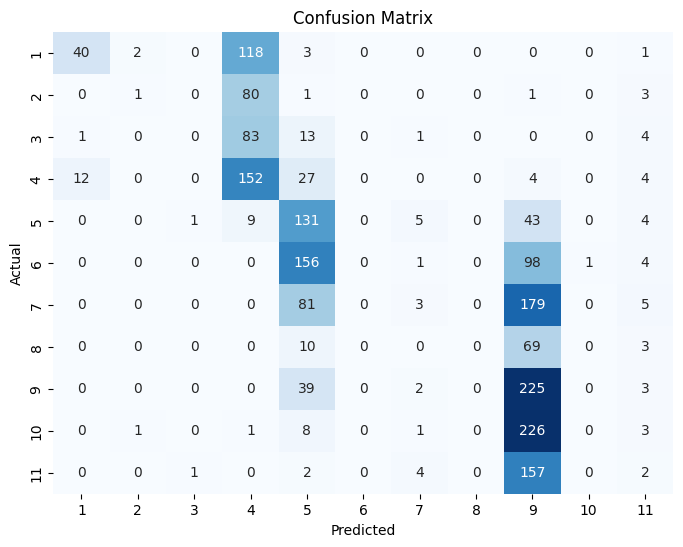

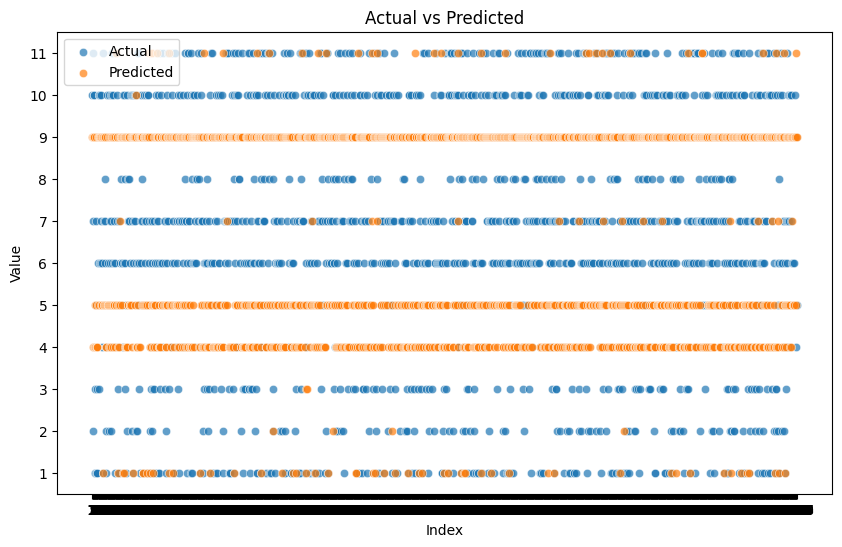

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 실제 값과 예측 값을 데이터프레임으로 변환
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes})

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(np.arange(0.5, 11.5, 1), np.arange(1, 12, 1))  # xticks 설정
plt.yticks(np.arange(0.5, 11.5, 1), np.arange(1, 12, 1))  # yticks 설정
plt.show()

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=result_df.index, y='Actual', data=result_df, label='Actual', alpha=0.7)
sns.scatterplot(x=result_df.index, y='Predicted', data=result_df, label='Predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.xticks(np.arange(0, len(result_df), 1), np.arange(1, len(result_df) + 1, 1))  # xticks 설정
plt.yticks(np.arange(1, 12, 1), np.arange(1, 12, 1))  # yticks 설정
plt.legend()
plt.show()


In [ ]:
print(X.shape)
print(y.shape)

(10144, 90, 17)
(10144,)


In [ ]:
# 데이터 스케일링
scaler = StandardScaler()
Scaled_X = scaler.fit_transform(X)


In [ ]:
df1

,record timestamp,client timestamp,button,state,x,y,y_label,delta_client_time,delta_x,delta_y,delta_dist,mouse_speed,slope,delta_slope,curvature,clicks_so_far,click_frequency
0,1.29,1.29,1,2,121,154,60,0.05,-13.0,-6.0,14.317821,286.356421,0.461538,0.169872,0.013067,1,0.775194
2,1.34,1.34,0,0,158,167,60,0.02,-22.0,-10.0,24.166092,1208.304597,0.454545,0.121212,0.005510,1,0.746269
4,1.36,1.36,0,0,201,184,60,0.01,-19.0,-7.0,20.248457,2024.845673,0.368421,-0.031579,0.001662,1,0.735294
6,1.37,1.37,0,0,235,197,60,0.02,-15.0,-7.0,16.552945,827.647268,0.466667,0.103030,0.006869,1,0.729927
8,1.39,1.39,0,0,261,208,60,0.01,-9.0,-4.0,9.848858,984.885780,0.444444,-0.055556,0.006173,1,0.719424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464012,598.31,598.31,0,0,387,417,69,0.01,-3.0,1.0,3.162278,316.227766,-0.333333,-0.333333,0.111111,88681,148.219151
4464015,598.34,598.34,0,0,393,416,69,0.04,-1.0,0.0,1.000000,25.000000,-0.000000,0.000000,0.000000,88681,148.211719
4464021,598.65,598.65,0,0,396,424,69,0.02,-1.0,-8.0,8.062258,403.112887,8.000000,6.000000,6.000000,88681,148.134970
4464024,598.69,598.69,0,0,398,438,69,0.01,-1.0,-5.0,5.099020,509.901951,5.000000,-1.000000,1.000000,88681,148.125073


In [ ]:
X = df1.drop(['y_label'], axis=1)  # Assuming 'session_id' is not a feature
# One-hot encode categorical columns
y = df1['y_label']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Display classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9999546252515169
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     45305
          10       1.00      1.00      1.00     76439
          11       1.00      1.00      1.00     52999
           2       1.00      1.00      1.00     27302
           3       1.00      1.00      1.00     31513
           4       1.00      1.00      1.00     66543
           5       1.00      1.00      1.00     58550
           6       1.00      1.00      1.00     79538
           7       1.00      1.00      1.00     91695
           8       1.00      1.00      1.00     27384
           9       1.00      1.00      1.00     81854

    accuracy                           1.00    639122
   macro avg       1.00      1.00      1.00    639122
weighted avg       1.00      1.00      1.00    639122



In [ ]:
y_test

3458889     6
1901428     4
4171544     9
4247948     9
4378197    10
           ..
2935434     5
4400118    10
3210952     5
162445      1
3389781     6
Name: y_label, Length: 639122, dtype: object

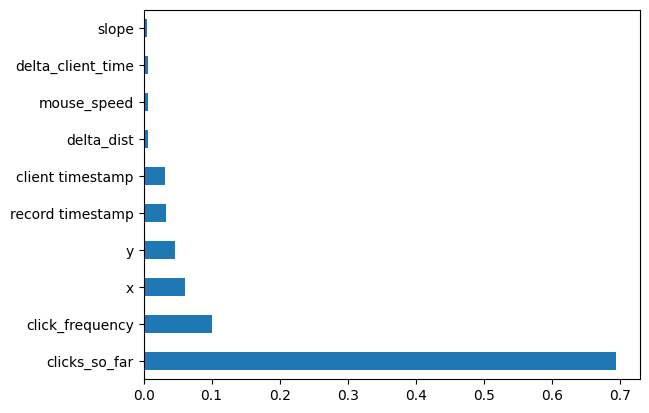

In [ ]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X_test.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
print(rf_model)

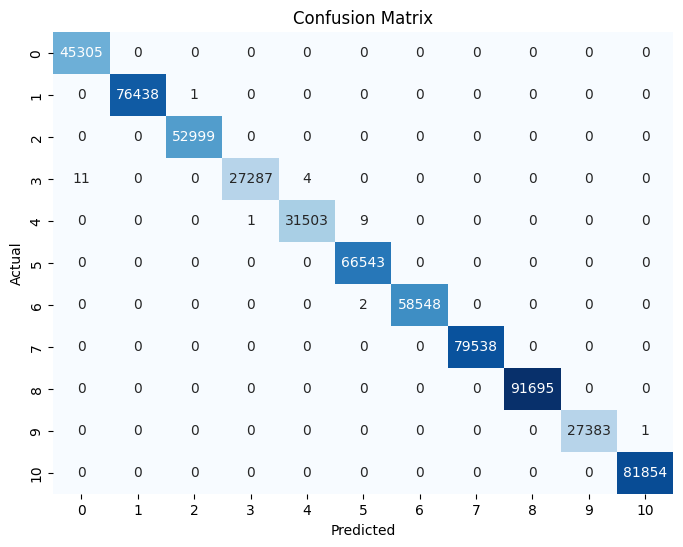

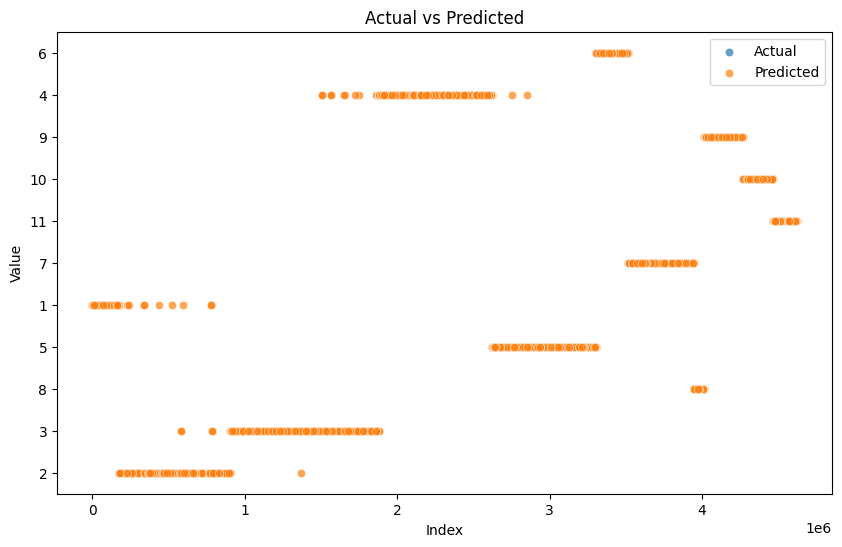

In [ ]:
import seaborn as sns

# 실제 값과 예측 값을 데이터프레임으로 변환
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=result_df.index, y='Actual', data=result_df, label='Actual', alpha=0.7)
sns.scatterplot(x=result_df.index, y='Predicted', data=result_df, label='Predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

<ipython-input-23-a2d8cc894099>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Cluster'] = kmeans.fit_predict(X_pca)


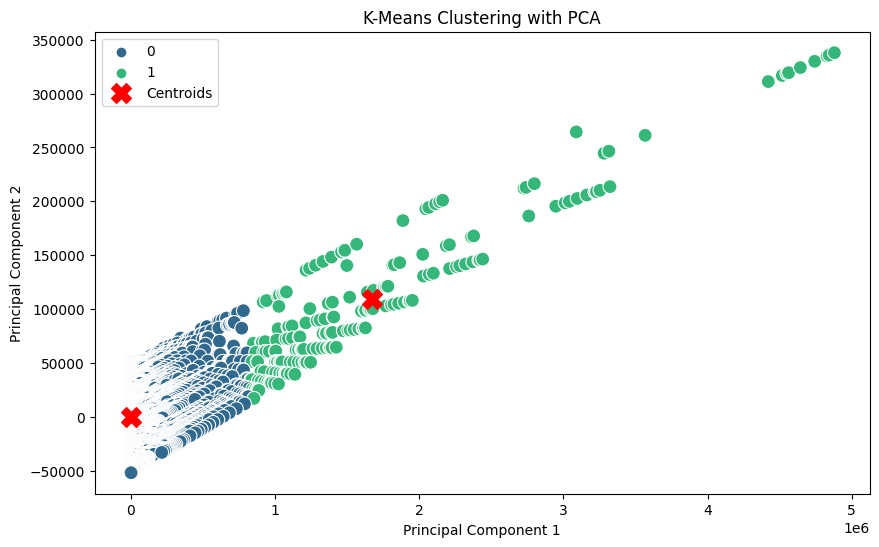

In [ ]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# PCA를 사용하여 데이터 차원 축소 (2차원으로 설정)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# K-Means 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df1['Cluster'] = kmeans.fit_predict(X_pca)

# 시각화
plt.figure(figsize=(10, 6))

# 산점도 그리기
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue='Cluster', data=df1, palette='viridis', s=100)

# 중심점 표시
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, color='red', label='Centroids')

plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
y_test.shape

(2029,)

In [ ]:
import pandas as pd

# 예측값과 실제값을 비교하여 새로운 칼럼 추가
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_classes})
results['Success'] = results.apply(lambda row: 1 if row['y_test'] == row['y_pred'] else 0, axis=1)

# 결과 확인
print(results)


      y_test  y_pred  Success
0       10.0       9        0
1        7.0       9        0
2        2.0       4        0
3       11.0       9        0
4       10.0       9        0
...      ...     ...      ...
2024    10.0       9        0
2025     4.0      11        0
2026     5.0       5        1
2027     9.0       9        1
2028     5.0       9        0

[2029 rows x 3 columns]


In [ ]:
import pickle

# 변수를 저장
with open('/content/drive/My Drive/your_file2.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
import pickle
# 변수를 불러오기
with open('/content/drive/My Drive/your_file2.pkl', 'rb') as f:
    result = pickle.load(f)

In [ ]:
result

,y_test,y_pred,Success
5621069,9,9,1
1595272,7,7,1
2195637,7,7,1
5576947,9,9,1
138864,7,7,1
...,...,...,...
5631426,9,9,1
2162787,7,7,1
1653108,7,7,1
4048171,9,9,1


In [ ]:
import pandas as pd

# 예측값과 실제값을 비교하여 새로운 칼럼 추가
mouse = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
mouse['Success'] = mouse.apply(lambda row: 1 if row['y_test'] == row['y_pred'] else 0, axis=1)

# 결과 확인
print(mouse)


        y_test y_pred  Success
1081775      7     16        0
1081776      7     16        0
1081777      7     16        0
1081778      7     16        0
1081779      7     16        0
...        ...    ...      ...
2027865     16     16        1
2027866     16     16        1
2027867     16     16        1
2027871     16     16        1
2027872     16     16        1

[519041 rows x 3 columns]


In [ ]:
import pandas as pd
from scipy.stats import chi2

# 예측 결과
y_pred = mouse['Success']
y_pred2 = result['Success']

# McNemar 검증을 위한 변수 초기화
a, b, c, d = 0, 0, 0, 0

# McNemar 검증 수행
for pred1, pred2 in zip(y_pred, y_pred2):
    if pred1 == pred2:
        if pred1 == 0:
            a += 1
        else:
            d += 1
    else:
        if pred1 == 0:
            b += 1
        else:
            c += 1

# McNemar 검증 통계량 계산
X2 = ((abs(b - c) - 1) ** 2) / (b + c)
df = 1
p_value = chi2.sf(X2, df)

# 결과를 데이터프레임으로 정리
results = {
    '': ['모델 1 성공', '모델 1 실패'],
    '모델 2 성공': [d, b],
    '모델 2 실패': [c, a]
}

df_results = pd.DataFrame(results)

# McNemar 검증 통계량 및 p-value 추가
df_results['McNemar 검증 통계량'] = [X2, '']
df_results['p-value'] = [p_value, '']

# 결과 출력
print(df_results)


            모델 2 성공  모델 2 실패 McNemar 검증 통계량 p-value
0  모델 1 성공        0        0   55688.000018     0.0
1  모델 1 실패    55690        0                       


In [ ]:
from scipy.stats import shapiro

# 예시 데이터 (data라는 변수에 데이터를 할당)
# data = [your_data_here]

# Shapiro-Wilk 검정을 사용하여 정규성 검정
stat, p = shapiro(Scaled_X)

# 결과 출력
alpha = 0.05  # 유의수준
print(f'Statistics={stat}, p-value={p}')
if p > alpha:
    print('데이터는 정규분포를 따릅니다 (귀무가설 기각불가)')
else:
    print('데이터는 정규분포를 따르지 않습니다 (귀무가설 기각)')

Statistics=0.3276243209838867, p-value=0.0
데이터는 정규분포를 따르지 않습니다 (귀무가설 기각)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
result_df

,Actual,Predicted
1844743,16,16
1159535,7,7
1777609,9,9
2002344,16,16
817346,9,9
...,...,...
114149,7,7
818687,9,9
132758,7,7
1455656,9,9


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 모델을 사용하여 테스트 데이터 예측
y_pred = model.predict(X_test)

# 모델 예측값을 클래스로 변환 (가장 높은 확률을 갖는 클래스 선택)
predicted_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, predicted_classes)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [ ]:
y_test

In [ ]:
import seaborn as sns

# 실제 값과 예측 값을 데이터프레임으로 변환
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=result_df.index, y='Actual', data=result_df, label='Actual', alpha=0.7)
sns.scatterplot(x=result_df.index, y='Predicted', data=result_df, label='Predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:


# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title('True vs Predicted')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df1['client timestamp'], df1['click_frequency'])
plt.title('Variation of Click Frequency with Client Timestamp')
plt.ylabel('Click Frequency')
plt.xlabel('Client Timestamp')

# x축 범위를 0부터 100까지로 설정
plt.xlim(0.0, 2000.0)
plt.ylim(0.0, 3.0)
plt.show()


In [ ]:
plt.scatter(df1['client timestamp'], df1['click_frequency'])
plt.title('Variation of Click Frequency with Client Timestamp')
plt.ylabel('Click Frequency')
plt.xlabel('Client Timestamp')
plt.show()

In [ ]:
plt.scatter(df1['client timestamp'], df1['mouse_speed'])
plt.title('Variation of Mouse Speed with Client Timestamp')
plt.xlabel('Client Timestamp')
plt.ylabel('Mouse Speed')
plt.show()

In [ ]:
plt.scatter(df1['client timestamp'], df1['curvature'])
plt.title('Variation of Curvature with Client Timestamp')
plt.xlabel('Client Timestamp')
plt.ylabel('Curvature')
plt.show()